In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1087.8923520587182
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4868.771237187274


In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

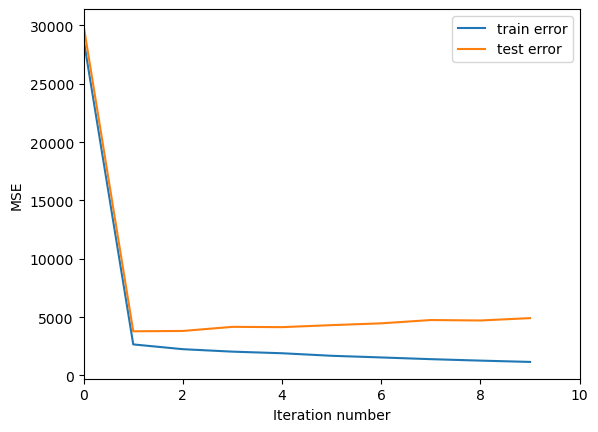

In [13]:
get_error_plot(n_trees, train_errors, test_errors)

In [14]:
def mse(n_trees, max_depth, X_train, X_test, y_train, y_test, eta = 1):
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    mse_train = mean_squared_error(y_train, train_prediction)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    mse_test = mean_squared_error(y_test, test_prediction)
    return  mse_train,  mse_test

In [32]:
def plot_dependency_mse_from_max_deep_and_n_trees(X_train, X_test, y_train, y_test, eta = 1, max_trees = 50, max_deep = 50):
    n_trees = np.arange(1, max_trees+1, 1)
    deeps = np.arange(1, max_deep+1, 1)
    n_trees, deeps = np.meshgrid(n_trees, deeps)
    mse_trains = np.zeros(n_trees.shape)
    mse_tests = np.zeros(n_trees.shape)
    for inx_deeps in range(n_trees.shape[0]):
        for inx_n_trees in range(n_trees.shape[1]):
            mse_train, mse_test = mse(n_trees[inx_deeps][inx_n_trees],deeps[inx_deeps][inx_n_trees],X_train, X_test, y_train, y_test, eta)
            mse_trains[inx_deeps][inx_n_trees] = mse_train
            mse_tests[inx_deeps][inx_n_trees] = mse_test
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(n_trees, deeps, mse_trains, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(n_trees, deeps, mse_tests, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()

In [33]:
plot_dependency_mse_from_max_deep_and_n_trees(X_train, X_test, y_train, y_test, eta = 1, max_trees = 25, max_deep = 10)

KeyboardInterrupt: 